In [1]:
#importing neccessary modules
import pandas as pd 
import sqlite3
import numpy as np 
import requests 
from bs4 import BeautifulSoup as BS
import matplotlib.pyplot as plt
import tabulate
from collections import Counter

%matplotlib inline 
conn = sqlite3.connect('im.db')
cur = conn.cursor()

In [2]:
#seeing available files 
! ls

Phase 1 Project Notebook.ipynb
README.md
Untitled.ipynb
bom.movie_gross.csv.gz
genre.txt
im.db
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


In [3]:
#opening and reviewing imdb datasets from movie_basics
imdb = pd.read_sql("""SELECT * FROM movie_basics;""", conn)
imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [4]:
#dropping unneccesary columns and rows 
imdb = imdb.drop(['original_title'], axis = 1)
imdb = imdb.drop(['movie_id'], axis = 1)
imdb = imdb.rename(columns={"primary_title" : "title"})
imdb = imdb.drop_duplicates(subset= "title")
imdb.head()

,title,start_year,runtime_minutes,genres
0,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,The Other Side of the Wind,2018,122.0,Drama
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
#opening and reviewing box office mojo dataset
gross = pd.read_csv("bom.movie_gross.csv.gz")
gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [6]:
#dropping unnecessary columns and duplicate movie tiles 
gross = gross.drop(['year'], axis = 1)
gross.drop_duplicates(subset=['title'])

,title,studio,domestic_gross,foreign_gross
0,Toy Story 3,BV,415000000.0,652000000
1,Alice in Wonderland (2010),BV,334200000.0,691300000
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000
3,Inception,WB,292600000.0,535700000
4,Shrek Forever After,P/DW,238700000.0,513900000
...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN
3383,Edward II (2018 re-release),FM,4800.0,NaN
3384,El Pacto,Sony,2500.0,NaN
3385,The Swan,Synergetic,2400.0,NaN


In [7]:
#printing column names in each dataset to find which to merge on
print(imdb.columns.tolist())
print(gross.columns.tolist())

['title', 'start_year', 'runtime_minutes', 'genres']
['title', 'studio', 'domestic_gross', 'foreign_gross']


In [8]:
#merging the imdb and gross datasets on "title"
df = imdb.merge(gross, how='outer', on='title')
df.head()

,title,start_year,runtime_minutes,genres,studio,domestic_gross,foreign_gross
0,Sunghursh,2013.0,175.0,"Action,Crime,Drama",NaN,NaN,NaN
1,One Day Before the Rainy Season,2019.0,114.0,"Biography,Drama",NaN,NaN,NaN
2,The Other Side of the Wind,2018.0,122.0,Drama,NaN,NaN,NaN
3,Sabse Bada Sukh,2018.0,NaN,"Comedy,Drama",NaN,NaN,NaN
4,The Wandering Soap Opera,2017.0,80.0,"Comedy,Drama,Fantasy",NaN,NaN,NaN


In [9]:
#checking the columns datatypes and converting them to the appropriate type
df['foreign_gross'] = pd.to_numeric(df['foreign_gross'], errors = 'coerce')
df.dtypes

title               object
start_year         float64
runtime_minutes    float64
genres              object
studio              object
domestic_gross     float64
foreign_gross      float64
dtype: object

In [10]:
#Finding Q3 for foreign_gross
foreign_Q3 = df['foreign_gross'].quantile(0.75)
print(foreign_Q3)

75050000.0


In [11]:
#limiting the dataset to show values only above the foreign_gross Q3
df = df[df['foreign_gross'] > 75050000.0]

df.head()

,title,start_year,runtime_minutes,genres,studio,domestic_gross,foreign_gross
54,The Secret Life of Walter Mitty,2013.0,114.0,"Adventure,Comedy,Drama",Fox,58200000.0,129900000.0
61,Spy,2011.0,110.0,"Action,Crime,Drama",Fox,110800000.0,124800000.0
71,Tangled,2010.0,100.0,"Adventure,Animation,Comedy",BV,200800000.0,391000000.0
73,John Carter,2012.0,132.0,"Action,Adventure,Sci-Fi",BV,73100000.0,211100000.0
95,The A-Team,2010.0,117.0,"Action,Adventure,Thriller",Fox,77200000.0,100000000.0


In [12]:
#sorting values in descending order by foreign_gross
df = df.sort_values(['foreign_gross'], ascending=False)
df.head()

,title,start_year,runtime_minutes,genres,studio,domestic_gross,foreign_gross
136200,Harry Potter and the Deathly Hallows Part 2,NaN,NaN,NaN,WB,381000000.0,960500000.0
37794,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi",BV,459000000.0,946400000.0
136292,Marvel's The Avengers,NaN,NaN,NaN,BV,623400000.0,895500000.0
80067,Jurassic World: Fallen Kingdom,2018.0,128.0,"Action,Adventure,Sci-Fi",Uni.,417700000.0,891800000.0
6575,Frozen,2010.0,93.0,"Adventure,Drama,Sport",BV,400700000.0,875700000.0


In [13]:
df = df.dropna(subset = ['genres'])
df.head()

,title,start_year,runtime_minutes,genres,studio,domestic_gross,foreign_gross
37794,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi",BV,459000000.0,946400000.0
80067,Jurassic World: Fallen Kingdom,2018.0,128.0,"Action,Adventure,Sci-Fi",Uni.,417700000.0,891800000.0
6575,Frozen,2010.0,93.0,"Adventure,Drama,Sport",BV,400700000.0,875700000.0
111301,Wolf Warrior 2,2017.0,123.0,"Action,Drama,Thriller",HC,2700000.0,867600000.0
28028,Transformers: Age of Extinction,2014.0,165.0,"Action,Adventure,Sci-Fi",Par.,245400000.0,858600000.0


In [14]:
#inserting space after comma 
df = df.replace(to_replace=',', value=', ', regex=True)
df.head()

,title,start_year,runtime_minutes,genres,studio,domestic_gross,foreign_gross
37794,Avengers: Age of Ultron,2015.0,141.0,"Action, Adventure, Sci-Fi",BV,459000000.0,946400000.0
80067,Jurassic World: Fallen Kingdom,2018.0,128.0,"Action, Adventure, Sci-Fi",Uni.,417700000.0,891800000.0
6575,Frozen,2010.0,93.0,"Adventure, Drama, Sport",BV,400700000.0,875700000.0
111301,Wolf Warrior 2,2017.0,123.0,"Action, Drama, Thriller",HC,2700000.0,867600000.0
28028,Transformers: Age of Extinction,2014.0,165.0,"Action, Adventure, Sci-Fi",Par.,245400000.0,858600000.0


In [15]:
#converting genre column to countable list
genres_list = df['genres'].tolist()
print(genres_list)

['Action, Adventure, Sci-Fi', 'Action, Adventure, Sci-Fi', 'Adventure, Drama, Sport', 'Action, Drama, Thriller', 'Action, Adventure, Sci-Fi', 'Adventure, Animation, Comedy', 'Action, Adventure, Fantasy', 'Action, Adventure, Sci-Fi', 'Action, Adventure, Fantasy', 'Action, Adventure, Thriller', 'Action, Adventure, Sci-Fi', 'Adventure, Animation, Comedy', 'Action, Adventure, Sci-Fi', 'Adventure, Family, Fantasy', 'Adventure, Animation, Comedy', 'Action, Adventure, Fantasy', 'Adventure, Fantasy', 'Adventure, Fantasy', 'Biography, Drama, Music', 'Adventure, Animation, Comedy', 'Action, Adventure, Thriller', 'Adventure, Animation, Comedy', 'Action, Adventure, Sci-Fi', 'Action, Thriller', 'Action, Adventure, Animation', 'Action, Adventure, Fantasy', 'Adventure, Animation, Comedy', 'Action, Drama, Thriller', 'Action, Adventure, Thriller', 'Action, Adventure, Comedy', 'Action, Crime, Thriller', 'Action, Adventure, Sci-Fi', 'Action, Adventure, Fantasy', 'Adventure, Animation, Comedy', 'Action, C

In [16]:
text = pd.read_table('genre.txt', names=['genre'])
text.head()

,genre
0,"'Action', 'Adventure', 'Sci-Fi', 'Action', 'Ad..."


In [17]:
from collections import Counter
def word_count(fname):
        with open(fname) as f:
                return Counter(f.read().split())

print("Number of words in the file :",word_count("genre.txt"))


Number of words in the file : Counter({"'Adventure',": 227, "'Action',": 210, "'Comedy',": 151, "'Drama',": 120, "'Animation',": 73, "'Thriller',": 69, "'Sci-Fi',": 62, "'Fantasy',": 50, "'Family',": 30, "'Romance',": 30, "'Crime',": 29, "'Mystery',": 27, "'Biography',": 24, "'Horror',": 22, "'History',": 12, "'Music',": 5, "'Western',": 4, "'Sport',": 3, "'Documentary',": 3, "'Musical',": 2, "'War',": 2, "'Romance,": 1, "Music',": 1, "'Sci-Fi'": 1})


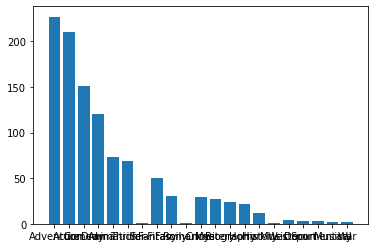

In [23]:
data = ({'Adventure': 227, 'Action': 210, 'Comedy': 151, 'Drama': 120, 'Animation': 73, 'Thriller': 69, 'Sci-Fi': 62, 'Fantasy': 50, 'Family': 30, 'Romance': 30, 'Crime': 29, 'Mystery': 27, 'Biography': 24, 'Horror': 22, 'History': 12, 'Music': 5, 'Western': 4, 'Sport': 3, 'Documentary': 3, 'Musical': 2, 'War': 2, 'Romance': 1, 'Music': 1, 'Sci-Fi': 1})
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

In [19]:
#counting the frequency of each studio

studio_counts = Counter(df['studio'])
print(studio_counts)

Counter({'Fox': 62, 'BV': 55, 'Uni.': 50, 'WB': 44, 'Sony': 43, 'Par.': 38, 'WB (NL)': 21, 'WGUSA': 12, 'LGF': 12, 'LG/S': 11, 'Wein.': 9, 'P/DW': 8, 'CL': 7, 'FoxS': 7, 'SGem': 5, 'TriS': 4, 'Sum.': 3, 'Rela.': 3, 'Focus': 3, 'Yash': 3, 'FUN': 2, 'STX': 2, 'HC': 1, 'FR': 1, 'UTV': 1, 'GrtIndia': 1, 'Magn.': 1, 'WAMCR': 1, 'W/Dim.': 1, nan: 1, 'LGP': 1, 'Vari.': 1, 'MGM': 1, 'EOne': 1, 'SPC': 1, 'MBox': 1, 'WHE': 1, 'RTWC': 1})


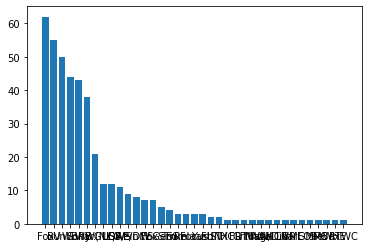

In [20]:
data = ({'Fox': 62, 'BV': 55, 'Uni.': 50, 'WB': 44, 'Sony': 43, 'Par.': 38, 'WB (NL)': 21, 'WGUSA': 12, 'LGF': 12, 'LG/S': 11, 'Wein.': 9, 'P/DW': 8, 'CL': 7, 'FoxS': 7, 'SGem': 5, 'TriS': 4, 'Sum.': 3, 'Rela.': 3, 'Focus': 3, 'Yash': 3, 'FUN': 2, 'STX': 2, 'HC': 1, 'FR': 1, 'UTV': 1, 'GrtIndia': 1, 'Magn.': 1, 'WAMCR': 1, 'W/Dim.': 1, 'LGP': 1, 'Vari.': 1, 'MGM': 1, 'EOne': 1, 'SPC': 1, 'MBox': 1, 'WHE': 1, 'RTWC': 1})
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()